<a href="https://colab.research.google.com/github/Amaljayaranga/Autoencoders/blob/master/Conv_Autoencoder_2020_4_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


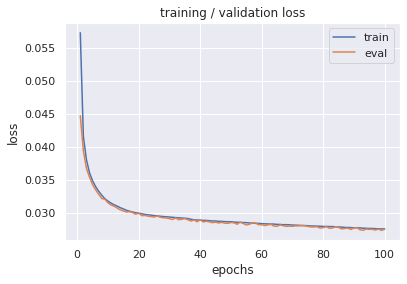

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from argparse import ArgumentParser
import seaborn as sns;sns.set()
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision


parser = ArgumentParser(description='Convolutional AutoEncoder')
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--learning_rate', type=float, default=1e-3)
parser.add_argument('--num_epochs', type=int, default=100)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--validation_split', type=float, default=0.3)
parser.add_argument('--mode', type=str, default='train')
parser.add_argument('--device', type=str, default='cuda')

args, unknown = parser.parse_known_args()

DEVICE = args.device
if not torch.cuda.is_available():
    DEVICE = 'cpu'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=3),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=2, stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

def draw_loss_plot(training_losses, validation_losses, epochs):
    plt.plot(epochs, training_losses, label="train")
    plt.plot(epochs, validation_losses, label="eval")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training / validation loss')
    plt.legend()
    plt.show()

def draw_accuracy_plot(testing_accuracy,  epochs):
    plt.plot(epochs, testing_accuracy, label="test")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('training / testing accuracy')
    plt.legend()
    plt.show()


train_dataset = MNIST('../data/MNIST', train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor()
                      ]))

test_dataset = MNIST('../data/MNIST', train=False, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor()
                     ]))

split = int(np.floor(args.validation_split * len(train_dataset)))
indices = list(range(len(train_dataset)))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                   sampler=train_sampler, drop_last=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                 sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)


model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)


if args.mode == 'train':
  
  train_epoch_losses = []
  eval_epoch_losses = []
  epoches = []

  train_epoch_accuracy = []
  test_epoch_accuracy = []

  for epoch in range(1, args.num_epochs+1):

    epoches.append(epoch)

    #training process
    model.train()
    torch.set_grad_enabled(True)

    for dataloader in [train_loader,val_loader]:
      
      train_batch_losses = []
      eval_batch_losses = []

      for batch in dataloader:
        images, labels = batch

        out = model(images)
        loss = criterion(out,images)

        if dataloader == train_loader:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item())

        else:
          eval_batch_losses.append(loss.item()) 

      if dataloader == train_loader:
        train_epoch_losses.append(np.mean(train_batch_losses))
      else:
        eval_epoch_losses.append(np.mean(eval_batch_losses))

  torch.save(model, './conv_autoencoder.pth')
  draw_loss_plot(train_epoch_losses,eval_epoch_losses,epoches ) 

if args.mode == 'test':
    #testing process
    model = torch.load('./conv_autoencoder.pth')
    model.eval()
    torch.set_grad_enabled(False)

    for dataloader in [test_loader]:
    
      train_batch_accuracy = []
      test_batch_accuracy = []

      for batch in dataloader:
        images, labels = batch
        out = model(images)
        mse = nn.MSELoss()
        accuracy = (1 - mse(out,images).item())*100
        test_batch_accuracy.append(accuracy)
    
    print('Accuracy', np.mean(test_batch_accuracy))

if args.mode == 'show':
    model = torch.load('./conv_autoencoder.pth')
    model.eval()

    img, _ = next(iter(train_loader))
    plt.imshow(img.numpy()[0].reshape(28,28), cmap='gray')
    plt.show()

    img = img.view(img.size(0), 1, 28, 28)
    img = Variable(img)
    output = model(img)
    plt.imshow(output.detach().numpy()[0].reshape(28,28), cmap='gray')
    plt.show()
